## auto encoder -> pca

In [5]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import os

np.random.seed(42)
tf.random.set_seed(42)

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [6]:
# 3d data set
np.random.seed(4)

def generate_3d_data(m, w1=0.1, w2=0.3, noise=0.1):
    angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
    data = np.empty((m, 3))
    data[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
    data[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
    data[:, 2] = data[:, 0] * w1 + data[:, 1] * w2 + noise * np.random.randn(m)
    return data

X_train = generate_3d_data(60)
X_train = X_train - X_train.mean(axis=0, keepdims=0)

In [7]:
np.random.seed(42)
tf.random.set_seed(42)

encoder = keras.models.Sequential([keras.layers.Dense(2, input_shape=[3])])
decoder = keras.models.Sequential([keras.layers.Dense(3, input_shape=[2])])
autoencoder = keras.models.Sequential([encoder, decoder])

autoencoder.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=1.5))

In [8]:
history = autoencoder.fit(X_train, X_train, epochs=20)
codings = encoder.predict(X_train)

Epoch 1/20
2/2 [==============================] - 0s 14ms/step - loss: 0.2547
Epoch 2/20
2/2 [==============================] - 0s 3ms/step - loss: 0.1032
Epoch 3/20
2/2 [==============================] - 0s 1ms/step - loss: 0.0551
Epoch 4/20
2/2 [==============================] - 0s 997us/step - loss: 0.0503
Epoch 5/20
2/2 [==============================] - 0s 1ms/step - loss: 0.0839
Epoch 6/20
2/2 [==============================] - 0s 1ms/step - loss: 0.2223
Epoch 7/20
2/2 [==============================] - 0s 996us/step - loss: 0.0913
Epoch 8/20
2/2 [==============================] - 0s 2ms/step - loss: 0.0320
Epoch 9/20
2/2 [==============================] - 0s 996us/step - loss: 0.0242
Epoch 10/20
2/2 [==============================] - 0s 1ms/step - loss: 0.0189
Epoch 11/20
2/2 [==============================] - 0s 1ms/step - loss: 0.0142
Epoch 12/20
2/2 [==============================] - 0s 2ms/step - loss: 0.0102
Epoch 13/20
2/2 [==============================] - 0s 982us/step -

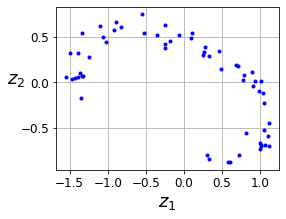

In [10]:
fig = plt.figure(figsize=(4,3))
plt.plot(codings[:,0], codings[:, 1], "b.")
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)
plt.show()

## mnist GAN 구현

In [11]:
codings_size = 30

generator = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[codings_size]),
    keras.layers.Dense(150, activation="selu"),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])

discriminator = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(150, activation="selu"),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(1, activation="sigmoid")
])
gan = keras.models.Sequential([generator, discriminator])

In [12]:
gan

In [13]:
discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
discriminator.trainable = False
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

In [15]:
batch_size = 32

dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

In [16]:
dataset

<PrefetchDataset element_spec=TensorSpec(shape=(32, 3), dtype=tf.float64, name=None)>

In [17]:
def train_gan(gan, dataset, batch_size, codings_size, n_epochs=50):
    generator, discriminator = gan.layers
    for epoch in range(n_epochs):
        print("Epoch {}/{}".format(epoch + 1, n_epochs))              # not shown in the book
        for X_batch in dataset:
            # phase 1 - training the discriminator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            generated_images = generator(noise)
            X_fake_and_real = tf.concat([generated_images, X_batch], axis=0)
            y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
            discriminator.trainable = True
            discriminator.train_on_batch(X_fake_and_real, y1)
            # phase 2 - training the generator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            y2 = tf.constant([[1.]] * batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y2)
        plot_multiple_images(generated_images, 8)                     # not shown
        plt.show()                                                    # not shown

In [19]:
train_gan(gan, dataset, batch_size, codings_size )

Epoch 1/50


InvalidArgumentError: cannot compute ConcatV2 as input #1(zero-based) was expected to be a float tensor but is a double tensor [Op:ConcatV2] name: concat